# Imports

In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

import numpy as np
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import xgboost as xgb

from PIL import Image

# Set Random Seed

In [15]:
import random
random.seed(7)

np.random.seed(7)

# Load Images

In [16]:
with open('/content/drive/My Drive/thesis/naip_chm_mask_3d.pkl', 'rb') as f:
    naip_chm_mask_3d = pickle.load(f)
    naip_chm_mask_3d = naip_chm_mask_3d[:,:,1]
    print(naip_chm_mask_3d.shape)

(10569, 11250)


In [17]:
# load the image
naip_natural_tiff = Image.open('/content/drive/MyDrive/thesis/training_images/naip_natural_.tif')

naip_natural_array = np.array(naip_natural_tiff)
print(naip_natural_array.shape)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (118901250 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(10569, 11250, 3)


In [18]:
binary_mask = np.where(naip_chm_mask_3d, 255, 0)

In [19]:
pixels = naip_natural_array.reshape(-1, naip_natural_array.shape[2])
zero_pixels_mask = np.all(pixels == 0, axis=-1)
pixels = pixels[~zero_pixels_mask]

binary_labels = (binary_mask.flatten() > 128).astype(int)
binary_labels = binary_labels[~zero_pixels_mask]

In [20]:
pixels.shape

(84432689, 3)

# Training RF Classifier

## Grid Search

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pixels, binary_labels, test_size=0.3, random_state=42)

rf = RandomForestClassifier()

# parameter grid
param_grid = {
    'n_estimators': [10, 12, 14, 16, 18],  # Number of trees in the forest
    'max_depth': [5, 10, 15, 20, 25],  # Maximum depth of the tree
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

# best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Fitting 3 folds for each of 25 candidates, totalling 75 fits


## Train Model

In [9]:
X_train, X_test, y_train, y_test = train_test_split(pixels, binary_labels, test_size=0.3, random_state=42)

## Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=14, random_state=42, max_depth=15, verbose=1, n_jobs=-1, class_weight='balanced')

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 out of  14 | elapsed:  8.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  14 out of  14 | elapsed:   14.4s finished


In [10]:
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 87.37%


# Evaluate Model

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  14 out of  14 | elapsed:   16.7s finished


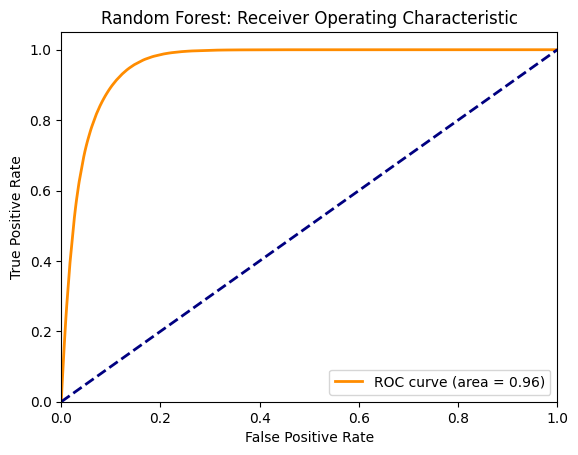

In [11]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities for the test set
y_probs = rf_classifier.predict_proba(X_test)[:, 1]  # probabilities for the positive class

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest: Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [12]:
# Method 1: Youden’s J statistic
J = tpr - fpr
optimal_idx = np.argmax(J)
optimal_threshold = thresholds[optimal_idx]

# Method 2: Minimizing the Euclidean distance to the top-left corner
distance = np.sqrt((1-tpr)**2 + fpr**2)
optimal_idx_distance = np.argmin(distance)
optimal_threshold_distance = thresholds[optimal_idx_distance]

print(f'Optimal threshold by Youden’s J: {optimal_threshold}')
print(f'Optimal threshold by Euclidean Distance: {optimal_threshold_distance}')

Optimal threshold by Youden’s J: 0.5210131202297283
Optimal threshold by Euclidean Distance: 0.6060396560100265


In [13]:
print(classification_report(y_test, y_probs>optimal_threshold_distance))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93  21184293
           1       0.61      0.92      0.73   4145514

    accuracy                           0.89  25329807
   macro avg       0.80      0.90      0.83  25329807
weighted avg       0.92      0.89      0.90  25329807

